In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install dtreeviz
!pip install fastbook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 14.2 MB/s eta 0:00:0000:01
/kaggle/input/credential/kaggle.json


In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Download Dataset

In [3]:
cred_path = Path('/kaggle/input/credential/kaggle.json').expanduser()

In [4]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path
     

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [6]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
username = user_secrets.get_secret("kaggle_username")
key = user_secrets.get_secret("kaggle_key")
os.environ["KAGGLE_USERNAME"] = username
os.environ["KAGGLE_KEY"] = key
api = KaggleApi()
api.authenticate()

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')
     

100%|██████████| 48.4M/48.4M [00:00<00:00, 97.5MB/s]


(#7) [Path('/root/.fastai/archive/bluebook-for-bulldozers/Test.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/TrainAndValid.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/Machine_Appendix.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/ValidSolution.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/Valid.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/median_benchmark.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/random_forest_benchmark_test.csv')]

In [7]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [8]:
df

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,...,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,...,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,...,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,...,NaN,NaN,NaN,NaN


In [9]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [10]:
df.columns.size

53

In [11]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [12]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

/tmp/ipykernel_35/2252637013.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [13]:
dep_var = 'SalePrice'
# metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices
# normalise the price
df[dep_var] = np.log(df[dep_var])

# Handling Dates

In [14]:
# replace every date column with a set of date metadata columns, such as holiday, day of week, and month
df = add_datepart(df, 'saledate')

# performing same on test
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [15]:
# new columns
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

# Data preprocessing

In [16]:
# using fast ai TabularPandas for data preprocessing
# replace columns with a numeric categorical column
# replace missing values with the median of the column, and create a new Boolean column 
# that is set to True for any row where the value was missing.
procs = [Categorify, FillMissing]

# Creating Validation Set

In [17]:
df.saleYear, df.saleMonth

(0         2006
 1         2004
 2         2004
 3         2011
 4         2009
           ... 
 412693    2012
 412694    2012
 412695    2012
 412696    2012
 412697    2012
 Name: saleYear, Length: 412698, dtype: int64,
 0         11
 1          3
 2          2
 3          5
 4          7
           ..
 412693     3
 412694     1
 412695     1
 412696     3
 412697     1
 Name: saleMonth, Length: 412698, dtype: int64)

In [18]:
df_test.saleYear, df_test.saleMonth

(0        2012
 1        2012
 2        2012
 3        2012
 4        2012
          ... 
 12452    2012
 12453    2012
 12454    2012
 12455    2012
 12456    2012
 Name: saleYear, Length: 12457, dtype: int64,
 0         5
 1         5
 2         5
 3         5
 4         5
          ..
 12452    10
 12453    10
 12454    10
 12455    10
 12456     9
 Name: saleMonth, Length: 12457, dtype: int64)

In [19]:
# date range represented in the test set, covers a six-month period from May 2012
# which is later in time than any date in the training set

#  validation set will consist of data from after November 2011

cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [20]:
# TabularPandas needs to be told which columns are continuous and which are categorical
# all string col is part of cat and integer whose cardinality is 1 or 0
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [21]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)


In [22]:
len(to.train),len(to.valid)

(404710, 7988)

In [23]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [24]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


# Saving the preprosses data

In [25]:
save_pickle(path/'to.pkl',to)
# to load
# to = (path/'to.pkl').load()

In [26]:
to = load_pickle(path/'to.pkl')

In [27]:
len(to)

412698

In [28]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [29]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [30]:
from fastbook import *

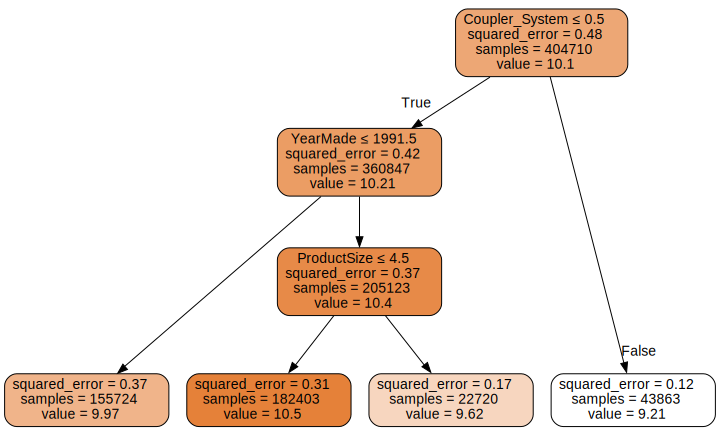

In [31]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [32]:
samp_idx = np.random.permutation(len(y))[:500]


In [33]:
 xs.iloc[samp_idx]

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
59694,0,747,245,31,0,0,0,2,44,1,1,2,3,2,2,1,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1318978,1273814,3538,132,1.0,1998,0.0,2003,9,38,17,2,260,1.063757e+09
120492,0,3141,1056,59,0,0,3,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,2,0,0,0,0,9,2,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,1,1,1,1,1,1,2,1462418,1522466,4336,132,1.0,2002,0.0,2006,9,39,27,2,270,1.159315e+09
235381,0,3912,1408,0,0,0,2,19,23,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,0,0,0,2,19,29,3,2,3,0,0,0,0,0,1,1,1,1,1,1,1,2,1733555,1558180,9055,132,1.0,1987,0.0,1992,4,17,21,1,112,7.038144e+08
50111,0,1076,326,78,0,0,0,2,9,1,1,2,6,1,2,1,2,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1292765,1138460,3171,132,2.0,1999,0.0,2006,12,50,13,2,347,1.165968e+09
282562,0,4562,1725,0,0,0,5,13,38,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,1,2,1,2,1,1,1,2,1885504,1358498,10912,132,2.0,1000,0.0,1994,10,39,1,5,274,7.809696e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274293,0,3601,1308,0,0,0,0,32,18,2,2,3,6,0,0,0,0,5,0,1,6,3,1,5,1,2,1,1,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1818700,1120000,9854,132,10.0,1000,0.0,2000,11,46,16,3,321,9.743328e+08
170715,0,494,176,15,0,0,0,2,6,1,1,4,1,1,2,1,2,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1598631,1084324,4600,132,1.0,1980,0.0,1994,9,38,22,3,265,7.801920e+08
208874,0,3507,1244,0,0,0,0,42,13,3,3,0,6,1,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1660300,1105503,14758,132,1.0,1998,0.0,2008,3,12,17,0,77,1.205712e+09
268994,0,1410,407,0,0,0,0,38,23,3,3,0,6,1,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1806736,1323042,9549,132,1.0,1999,0.0,2008,3,13,25,1,85,1.206403e+09


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


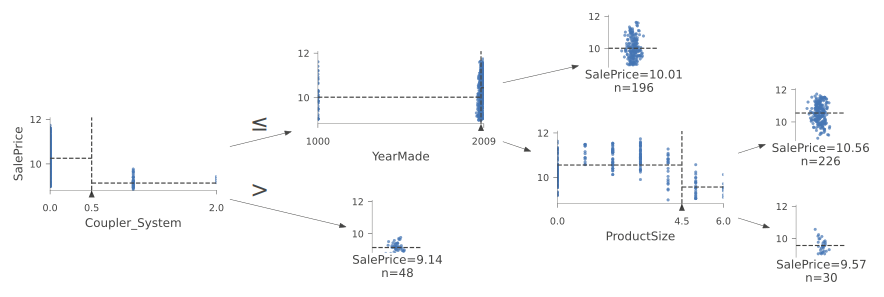

In [34]:
import dtreeviz
samp_idx = np.random.permutation(len(y))[:500]
viz_model=dtreeviz.model(m,
                   X_train=xs.iloc[samp_idx],
                   y_train=y.iloc[samp_idx],
                   feature_names=xs.columns,
                   target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')


In [35]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


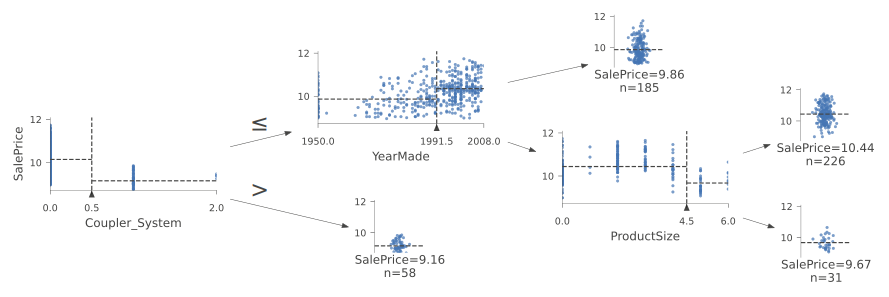

In [36]:

samp_idx = np.random.permutation(len(y))[:500]
viz_model=dtreeviz.model(m,
                   X_train=xs.iloc[samp_idx],
                   y_train=y.iloc[samp_idx],
                   feature_names=xs.columns,
                   target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

In [37]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [38]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

## The above tree is overfitting

In [39]:
# error on test set
m_rmse(m, xs, y)

0.0

In [40]:
# error on validation set
m_rmse(m, valid_xs, valid_y)

0.331994

In [41]:
m.get_n_leaves(), len(xs)


(324562, 404710)

### Reduce the number of tree leaf

In [42]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248595, 0.323357)

In [43]:
m.get_n_leaves()

12397

### Using bagging to improve accuracy 

In [44]:
# n_estimators defines the number of trees
# max_samples defines how many rows to sample for training each tree
# max_features defines how many columns to sample at each split point

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [45]:
m = rf(xs, y);

In [46]:
xs.shape, y.shape, m.predict(xs).shape

((404710, 66), (404710,), (404710,))

In [47]:
help(m_rmse)

Help on function m_rmse in module __main__:

m_rmse(m, xs, y)



In [48]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171127, 0.233876)

In [49]:
valid_xs_values = valid_xs.values
preds = np.stack([t.predict(valid_xs_values) for t in m.estimators_])

In [50]:
valid_xs_values.shape, preds.shape, preds.mean(0).shape

((7988, 66), (40, 7988), (7988,))

In [51]:
r_mse(preds.mean(0), r_mse(m.oob_prediction_, y))


9.979782

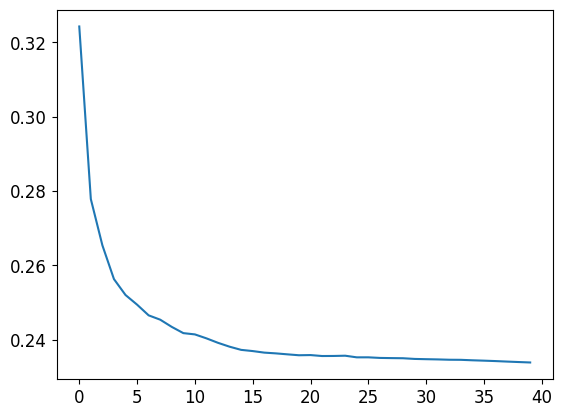

In [52]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error


In [53]:
# The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees 
# where that row was not included in training
r_mse(m.oob_prediction_, y)

0.211043

In [54]:
valid_xs.shape, len(m.estimators_),len(m.estimators_[0].predict(valid_xs))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names


((7988, 66), 40, 7988)

In [55]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X 

In [56]:
preds.shape

(40, 7988)

In [57]:
preds_std = preds.std(0)

In [58]:
preds_std[:5]

array([0.21784321, 0.09272169, 0.10130819, 0.28946785, 0.12857923])

## Feature Importance

In [59]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [60]:
# YearMade and ProductSize contribute the most
fi = rf_feat_importance(m, xs)
print(fi.shape)
fi[:10]


(66, 2)


,cols,imp
57,YearMade,0.179306
6,ProductSize,0.114431
30,Coupler_System,0.095189
7,fiProductClassDesc,0.072975
31,Grouser_Tracks,0.064726
54,ModelID,0.059361
65,saleElapsed,0.049823
3,fiSecondaryDesc,0.041274
12,Enclosure,0.036006
1,fiModelDesc,0.034843


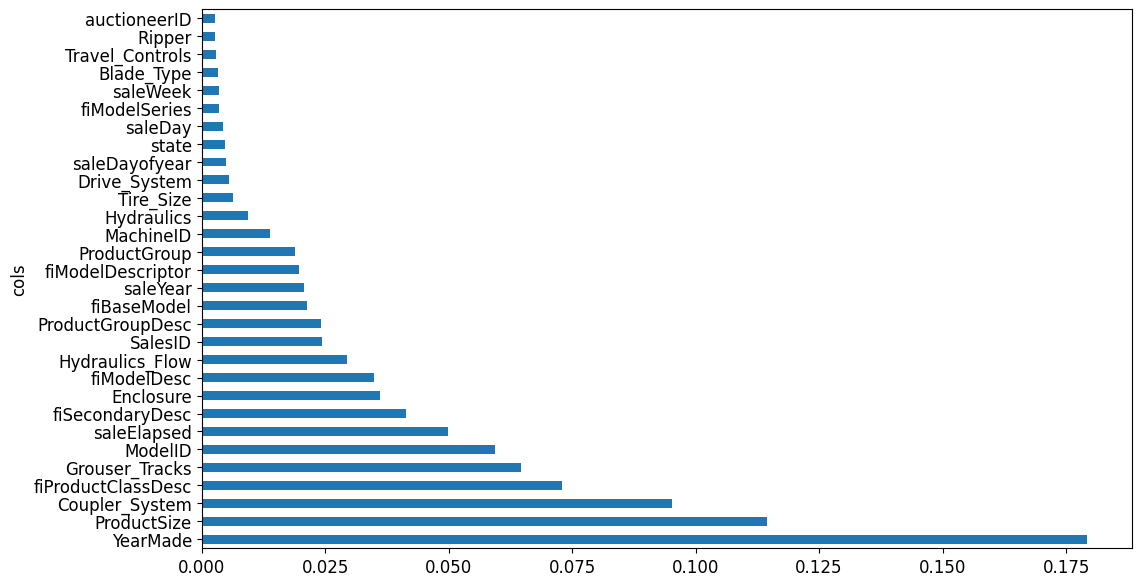

In [61]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

## Removing Low-Importance Variables

In [62]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [63]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [64]:
m = rf(xs_imp, y)

In [65]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181224, 0.231402)

In [66]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

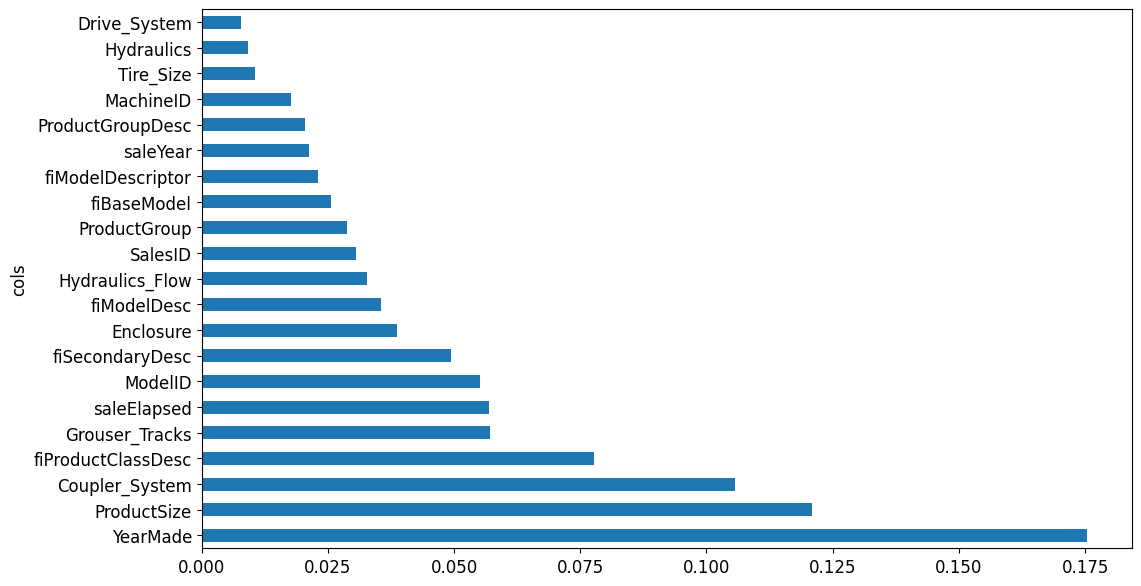

In [67]:
plot_fi(rf_feat_importance(m, xs_imp));

## Removing Redundant Features

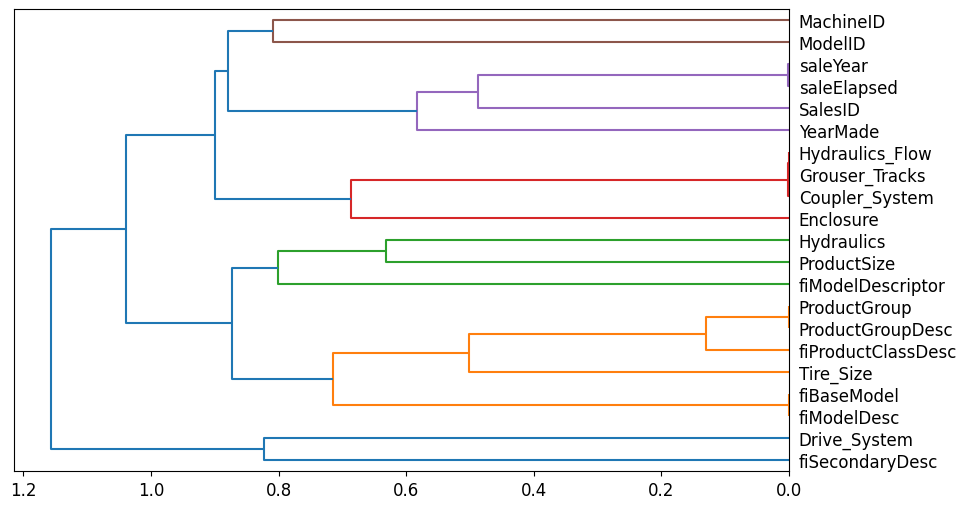

In [68]:
cluster_columns(xs_imp)

In [69]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [70]:
get_oob(xs_imp)

0.8774118373103568

In [71]:
# Now we try removing each of our potentially redundant variables, one at a time
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8765327562834951,
 'saleElapsed': 0.8721109353232122,
 'ProductGroupDesc': 0.8777828442414278,
 'ProductGroup': 0.8774997770498374,
 'fiModelDesc': 0.8757507018035072,
 'fiBaseModel': 0.8767422236587715,
 'Hydraulics_Flow': 0.877412273406593,
 'Grouser_Tracks': 0.8773485751312518,
 'Coupler_System': 0.877728983311666}

In [72]:
# dropping multiple variables
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))
     

0.8740714957391719

In [73]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [74]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [75]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183261, 0.2331)

## Partial Dependence

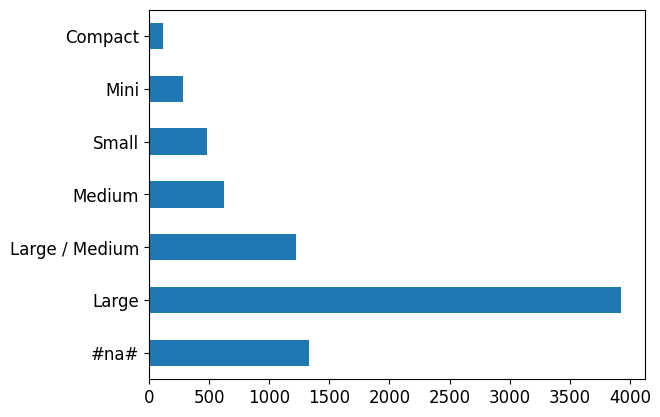

In [76]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);
     

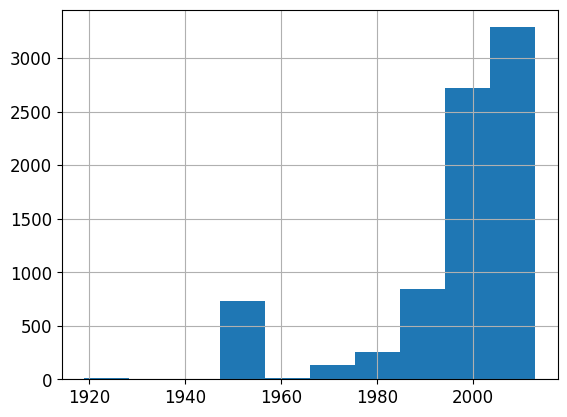

In [77]:
ax = valid_xs_final['YearMade'].hist()

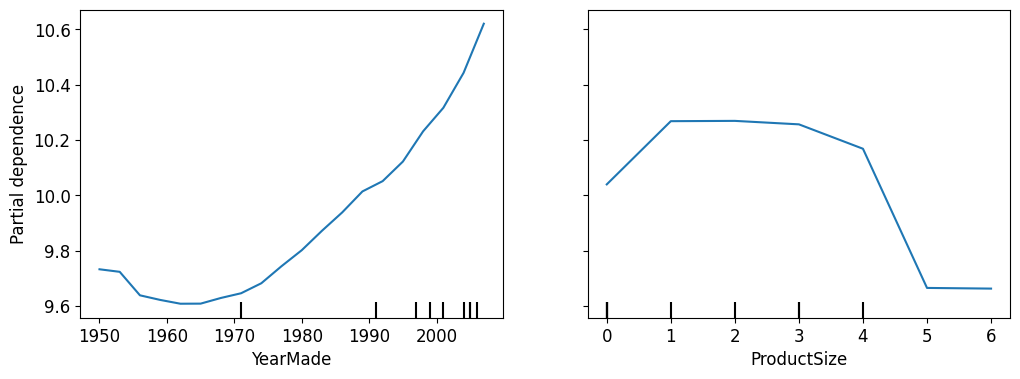

In [88]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

## Tree Interpreter

In [90]:
!pip install treeinterpreter
!pip install waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3415 sha256=d80d2dd75d9bcf3f28d8952a00a564bd79a07018b95780d86806ff2395d56660
  Stored in directory: /root/.cache/pip/wheels/bd/34/6c/58fce34a3b8ec5607aff650db14ceb41db8223ac217423371b
Successfully built waterfallcharts


In [91]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [92]:
row = valid_xs_final.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [93]:
prediction.shape, bias.shape, contributions.shape

((5, 1), (5,), (5, 17))

In [94]:
prediction[0], bias[0], contributions[0].sum()

(array([10.02943828]), 10.104187853605985, -0.07474957271483601)

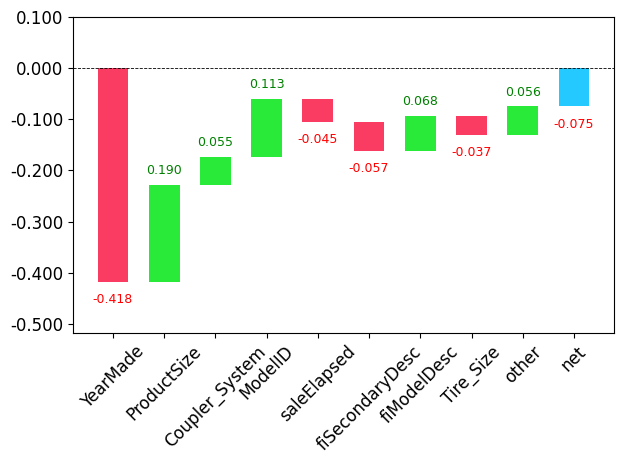

In [95]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

In [97]:
# Random forests are not able to extrapolate outside of the types of 
# data they have seen, in a more general sense

## Finding Out-of-Domain Data

In [98]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.888946
10,SalesID,0.091037
13,MachineID,0.015633
0,YearMade,0.001077
4,ModelID,0.000993
7,Enclosure,0.000445


In [100]:
# removing each of these columns in turn
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232835
SalesID 0.230508
saleElapsed 0.235579
MachineID 0.230921


In [101]:
# we should be able to remove SalesID and MachineID without losing any accuracy
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228802

In [102]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.22909

In [ ]:
xs['saleYear'].hist();

In [104]:
# remove old data
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [105]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177902, 0.229332)

## Using a Neural Network

In [106]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [109]:
print(list(xs_final_time.columns))

['YearMade', 'ProductSize', 'Coupler_System', 'fiProductClassDesc', 'ModelID', 'saleElapsed', 'fiSecondaryDesc', 'Enclosure', 'fiModelDesc', 'Hydraulics_Flow', 'fiModelDescriptor', 'ProductGroup', 'Hydraulics', 'Tire_Size', 'Drive_System']


In [107]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [110]:
#  To create embeddings, fastai needs to determine which columns should be treated as 
# categorical variables
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)
     


In [111]:
cont_nn

['saleElapsed']

In [112]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
Hydraulics_Flow          3
fiModelDescriptor      140
ProductGroup             6
Hydraulics              12
Tire_Size               17
Drive_System             4
dtype: int64

In [113]:
df_nn_final[cont_nn].nunique()

saleElapsed    4013
dtype: int64

In [115]:
# two variables pertaining to the "model" of the equipment, both with similar very high cardinalities, suggests
# that they may contain similar, redundant information
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)


(0.176696, 0.229457)

In [116]:
cat_nn.remove('fiModelDescriptor')

In [117]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [118]:
dls = to_nn.dataloaders(1024)

In [119]:
# it's a good idea to set y_range for regression models, so let's find the min and max 
# of our dependent variable
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

In [120]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.00019054606673307717)

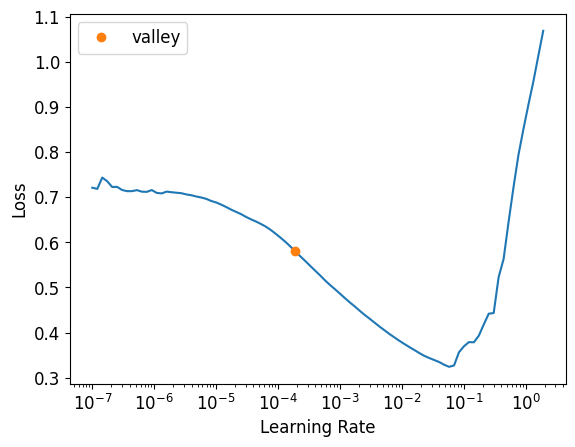

In [121]:
learn.lr_find()

In [122]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062674,0.070476,00:31
1,0.054149,0.054517,00:32
2,0.047571,0.061171,00:33
3,0.043512,0.050662,00:32
4,0.040283,0.050184,00:31


In [123]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.224019

In [124]:
learn.save('nn')

Path('models/nn.pth')

## Ensembling Random forest and Neural Network

In [125]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [126]:
r_mse(ens_preds,valid_y)

0.22149